In [4]:
import pandas as pd
import numpy as np
import math
import json
from matplotlib import pyplot as plt
import datetime

% matplotlib inline


pd.options.display.float_format = "{:.2f}".format


# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [2]:
# Deleting NaN values
profile = profile.dropna()

In [3]:
clean_transcript = transcript.copy()
clean_transcript["offer_id"] = clean_transcript['value'].apply(lambda x: x['offer id'] if ('offer id' in x) else x['offer_id'] if ('offer_id' in x) else -1)

In [4]:

# Get for how long a user has been a client
maxtime = profile['became_member_on'].max() + 1

date_time_obj = datetime.datetime.strptime(str(maxtime), '%Y%m%d').date()
profile['user_day'] = date_time_obj - pd.to_datetime(profile['became_member_on'], format='%Y%m%d').dt.date
profile['user_day'] = profile['user_day'].dt.days



In [4]:
def get_timeline_results(timeline):
    recived = timeline[timeline['event']=='offer received']
    viewed = timeline[timeline['event']=='offer viewed']
    complete = timeline[timeline['event']=='offer completed']
    real_complete = 0
    # Todo check all of them with shape
    for i in range(recived.shape[0]):
        try:
            if recived["time"].values[i] <= viewed["time"].values[i] <= complete["time"].values[i]:
                real_complete += 1
        except:
            pass
    return recived.shape[0], viewed.shape[0], complete.shape[0], real_complete


def get_offers_for_users(users, transcript, offers):
    column_list = ['user_id', 'offer_id', "recived", "viewed", "complete", "real_complete"]
    df = pd.DataFrame(columns=column_list) 
    
    for user in users:
        for offer in offers:
            timeline = transcript[(transcript['person']==user) & (transcript['offer_id']==offer)]
            if not timeline.empty:
                total_count = get_timeline_results(timeline)
                a = [user] + [offer] + list(total_count)
                c =  pd.DataFrame([a], columns=column_list)
                df = df.append( pd.DataFrame(c, columns=column_list))
    return df


In [5]:
# Instead calculate all the matrix (2h) a pickle is readed

In [45]:
%%time
offers_id = portfolio.id.unique()
#user_ofer_matrix = get_offers_for_users(profile["id"], clean_transcript, offers_id)

CPU times: user 1.11 ms, sys: 129 µs, total: 1.24 ms
Wall time: 2.32 ms


In [48]:
import pandas as pd
user_ofer_matrix = pd.read_pickle("./user_ofer_matrix.pkl")


In [49]:
user_ofer_matrix.head()

,user_id,offer_id,recived,viewed,complete,real_complete
0,0610b486422d4921ae7d2bf64640c50b,3f207df678b143eea3cee63160fa8bed,1,0,0,0
0,0610b486422d4921ae7d2bf64640c50b,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,1,0
0,78afa995795e4d85b5d9ceeca43f5fef,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,1
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,1
0,78afa995795e4d85b5d9ceeca43f5fef,5a8bc65990b245e5a138643cd4eb9837,1,1,0,0


In [50]:
%%time

# Cuantas ofertas se cmpletan
r_c = user_ofer_matrix[user_ofer_matrix["real_complete"] > 0]

offers_sum = []
for i in offers_id:
    offers_sum.append(r_c[r_c["offer_id"] == i]["real_complete"].sum())
    

CPU times: user 39.6 ms, sys: 3.96 ms, total: 43.6 ms
Wall time: 44.7 ms


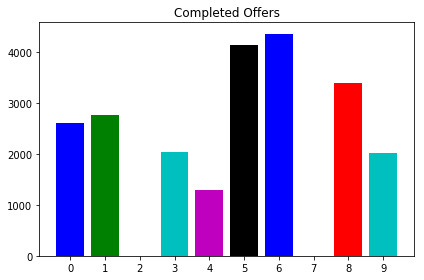

In [54]:
from itertools import cycle
cycol = cycle('bgrcmk')

y_pos = np.arange(len(offers_id))
plt.bar(y_pos, offers_sum, color=[next(cycol) for i in y_pos])
plt.xticks(y_pos, y_pos)
plt.title('Completed Offers')
plt.legend()
plt.tight_layout()

plt.show()

# Offers

As we can see the offer 5th and 6th are the most completed ones (**3 and 2 discounts**) follow by the 8th (**BOGO of 5**)

The others have more or less the half of the top ones

In [5]:
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [11]:
%%time

# Distribucion de ofertas cumplidas por income
incomes = []
for i in offers_id:
    income = []
    for us in r_c[r_c["offer_id"] == i]["user_id"].values:
        income.append(profile[profile["id"] == us]["income"].values[0])
    incomes.append(income)

CPU times: user 40.6 s, sys: 6.69 ms, total: 40.6 s
Wall time: 40.7 s


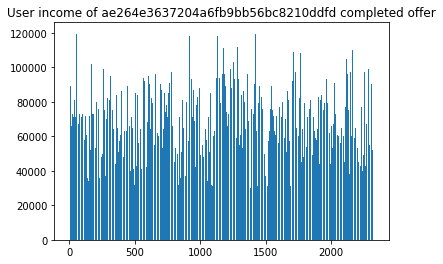

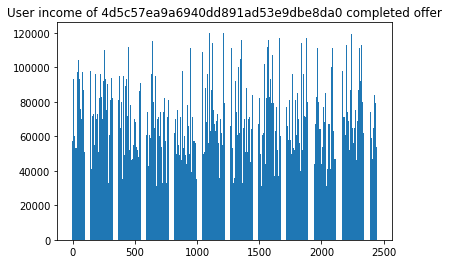

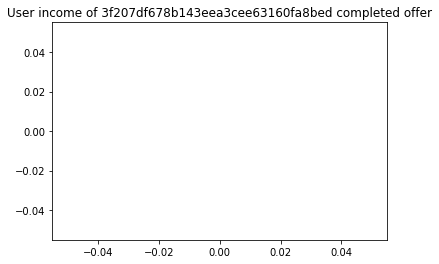

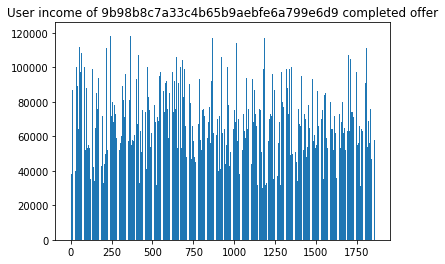

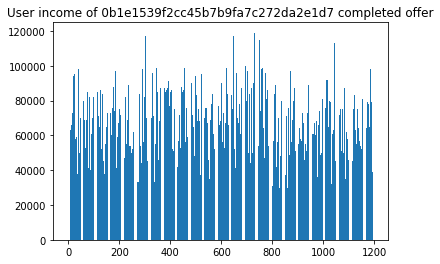

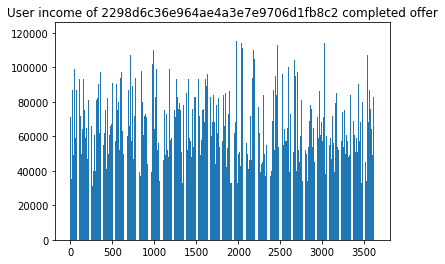

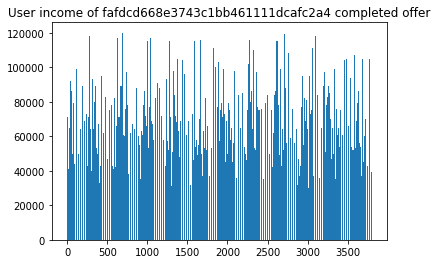

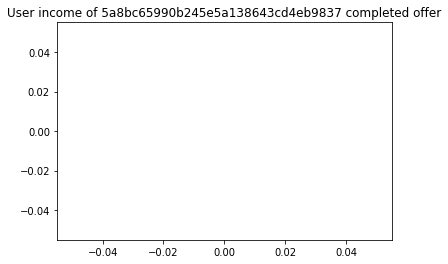

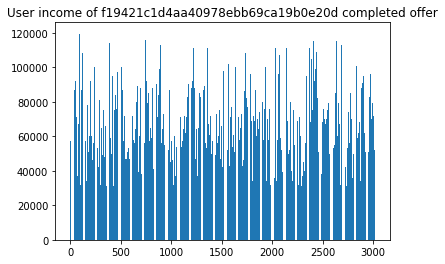

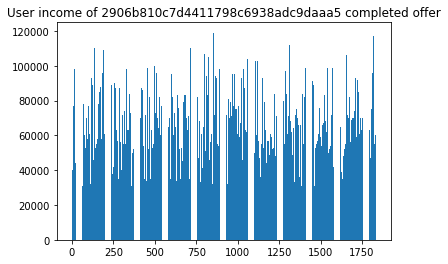

In [12]:

for inc, off in zip(incomes, offers_id):
    plt.title('User income of {} completed offer'.format(off))
    plt.bar( np.arange(len(inc)),inc)
    plt.show()


# Offers

There isnt any remarcable data about the income on the completed offers

In [51]:
%%time

# Distribucion de ofertas cumplidas por sexo
# We left 
men_means = []
women_means = []
other_means = []

for i in offers_id:
    gender = []
    for us in r_c[r_c["offer_id"] == i]["user_id"].values:
        gender.append(profile[profile["id"] == us]["gender"].values[0])
    man = len([s for s in gender if "M" in s])
    woman = len([s for s in gender if "F" in s])
    oth = len([s for s in gender if "O" in s])

    men_means.append(man)
    women_means.append(woman)
    other_means.append(oth)


CPU times: user 39.4 s, sys: 12.4 ms, total: 39.4 s
Wall time: 39.7 s


In [52]:
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

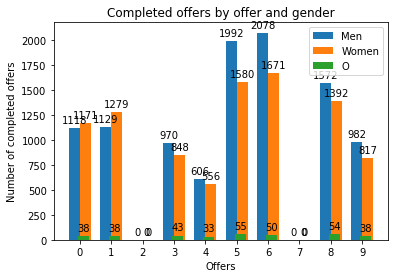

In [55]:

labels = y_pos.tolist()

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()

rects1 = ax.bar(x - width/2, men_means, width, label='Men')
rects2 = ax.bar(x + width/2, women_means, width, label='Women')
rects3 = ax.bar(x + width/3, other_means, width, label='O')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number of completed offers')
ax.set_xlabel('Offers')

ax.set_title('Completed offers by offer and gender')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


autolabel(rects1)
autolabel(rects2)
autolabel(rects3)


plt.show()

# Offers

There are more Mens who complete the top offers but on the other completed offers the differences aren't remarcable

The _Others_ gnere are underrepresentated 

# Data Preparation

For training purposes the completed offers are encoded with the user-completed_offer one hot encoded

In [135]:
y_data_columns = ["user_id"] + list(portfolio.id.unique())
y_dataset = pd.DataFrame(columns =y_data_columns)

In [136]:
%%time

for index, row in profile.iterrows():
    zeros = [row["id"]] + [0]*(len(y_data_columns)-1)
    df = pd.DataFrame([zeros], columns=y_data_columns)
    for i in user_ofer_matrix[(user_ofer_matrix["user_id"] == row["id"]) & (user_ofer_matrix["real_complete"] == 1)]["offer_id"].values:
        df[i] = 1
    y_dataset = y_dataset.append(pd.DataFrame(df, columns=y_data_columns))

CPU times: user 4min 33s, sys: 1e+03 ms, total: 4min 34s
Wall time: 4min 35s


In [137]:
y_dataset = y_dataset.reset_index()

In [138]:
del y_dataset['index']

In [139]:
y_dataset.head()

,user_id,ae264e3637204a6fb9bb56bc8210ddfd,4d5c57ea9a6940dd891ad53e9dbe8da0,3f207df678b143eea3cee63160fa8bed,9b98b8c7a33c4b65b9aebfe6a799e6d9,0b1e1539f2cc45b7b9fa7c272da2e1d7,2298d6c36e964ae4a3e7e9706d1fb8c2,fafdcd668e3743c1bb461111dcafc2a4,5a8bc65990b245e5a138643cd4eb9837,f19421c1d4aa40978ebb69ca19b0e20d,2906b810c7d4411798c6938adc9daaa5
0,0610b486422d4921ae7d2bf64640c50b,0,0,0,0,0,0,0,0,0,0
1,78afa995795e4d85b5d9ceeca43f5fef,1,0,0,1,0,0,0,0,0,0
2,e2127556f4f64592b11af22de27a7932,0,0,0,1,0,0,1,0,0,0
3,389bc3fa690240e798340f5a15918d5c,0,0,0,1,0,0,1,0,0,1
4,2eeac8d8feae4a8cad5a6af0499a211d,0,0,0,0,0,0,1,0,0,0


In [140]:
y_dataset.to_pickle("./y_dataset.pkl")

In [6]:
y_dataset = pd.read_pickle("./y_dataset.pkl")


In [7]:
y_dataset.shape

(14825, 11)

In [8]:
y_dataset.head()

,user_id,ae264e3637204a6fb9bb56bc8210ddfd,4d5c57ea9a6940dd891ad53e9dbe8da0,3f207df678b143eea3cee63160fa8bed,9b98b8c7a33c4b65b9aebfe6a799e6d9,0b1e1539f2cc45b7b9fa7c272da2e1d7,2298d6c36e964ae4a3e7e9706d1fb8c2,fafdcd668e3743c1bb461111dcafc2a4,5a8bc65990b245e5a138643cd4eb9837,f19421c1d4aa40978ebb69ca19b0e20d,2906b810c7d4411798c6938adc9daaa5
0,0610b486422d4921ae7d2bf64640c50b,0,0,0,0,0,0,0,0,0,0
1,78afa995795e4d85b5d9ceeca43f5fef,1,0,0,1,0,0,0,0,0,0
2,e2127556f4f64592b11af22de27a7932,0,0,0,1,0,0,1,0,0,0
3,389bc3fa690240e798340f5a15918d5c,0,0,0,1,0,0,1,0,0,1
4,2eeac8d8feae4a8cad5a6af0499a211d,0,0,0,0,0,0,1,0,0,0


# Data Preparation

The data that is used for training will be:

- age
- gender
- income
- days a user has been a user


The age, income and user_day will be normalized and the gender will be one-hot-encoded

In [57]:
x_dataset = profile.copy()

In [58]:
del x_dataset['became_member_on']

In [60]:
x_dataset.head()

,age,gender,id,income,user_day
1,55,F,0610b486422d4921ae7d2bf64640c50b,112000.00,377
3,75,F,78afa995795e4d85b5d9ceeca43f5fef,100000.00,444
5,68,M,e2127556f4f64592b11af22de27a7932,70000.00,92
8,65,M,389bc3fa690240e798340f5a15918d5c,53000.00,168
12,58,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.00,258


In [61]:
x_dataset = pd.get_dummies(x_dataset, columns=['gender'])
x_dataset.head()

,age,id,income,user_day,gender_F,gender_M,gender_O
1,55,0610b486422d4921ae7d2bf64640c50b,112000.00,377,1,0,0
3,75,78afa995795e4d85b5d9ceeca43f5fef,100000.00,444,1,0,0
5,68,e2127556f4f64592b11af22de27a7932,70000.00,92,0,1,0
8,65,389bc3fa690240e798340f5a15918d5c,53000.00,168,0,1,0
12,58,2eeac8d8feae4a8cad5a6af0499a211d,51000.00,258,0,1,0


In [68]:
df = x_dataset.copy()

In [72]:

column_names_to_normalize = ["age","income","user_day"]
x = x_dataset[column_names_to_normalize].values
x_scaled = min_max_scaler.fit_transform(x)
x_dataset[column_names_to_normalize] = pd.DataFrame(x_scaled, columns=column_names_to_normalize, index = df.index)


In [74]:
x_dataset.head()

,age,id,income,user_day,gender_F,gender_M,gender_O
1,0.45,0610b486422d4921ae7d2bf64640c50b,0.91,0.21,1,0,0
3,0.69,78afa995795e4d85b5d9ceeca43f5fef,0.78,0.24,1,0,0
5,0.60,e2127556f4f64592b11af22de27a7932,0.44,0.05,0,1,0
8,0.57,389bc3fa690240e798340f5a15918d5c,0.26,0.09,0,1,0
12,0.48,2eeac8d8feae4a8cad5a6af0499a211d,0.23,0.14,0,1,0


In [75]:
x_dataset.to_pickle("./x_dataset.pkl")